### CNN From Scratch - Week 1: Gradient and MNIST Tests
### This notebook tests from-the scratch implementation of the layers and optimizers.

In [ ]:
pip install scikit-learn


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import urllib.request
import gzip
import pickle
import os

### 1. Importation de nos classes

In [13]:
import sys
sys.path.append('C:/Users/Alien/Desktop/cnn-from-scratch/src')
from layers import Dense, ReLU, Softmax
from losses import CrossEntropyLoss
from optimizers import SGD, Adam
from model import Sequential

### 2. Tests de Gradient Numérique

In [14]:
def numerical_gradient(f, x, eps=1e-6):
    grad = np.zeros_like(x)
    for i in range(x.size):
        x_plus = x.copy()
        x_minus = x.copy()
        x_plus.flat[i] += eps
        x_minus.flat[i] -= eps
        grad.flat[i] = (f(x_plus) - f(x_minus)) / (2 * eps)
    return grad

def test_layer_gradients():
    print("Testing layer gradients...")
    
    # Dense layer test
    np.random.seed(42)
    X = np.random.randn(3, 4)
    layer = Dense(4, 3)
    
    output = layer.forward(X)
    grad_output = np.random.randn(*output.shape)
    grad_input = layer.backward(grad_output)
    
    def f_w(w_flat):
        w = w_flat.reshape(layer.W.shape)
        original_W = layer.W.copy()
        layer.W = w
        out = layer.forward(X)
        layer.W = original_W
        return np.sum(out)
    
    numerical_grad_W = numerical_gradient(f_w, layer.W)
    print(f"Dense W gradient error: {np.max(np.abs(layer.grad_W - numerical_grad_W)):.2e}")
    
    def f_b(b_flat):
        b = b_flat.reshape(layer.b.shape)
        original_b = layer.b.copy()
        layer.b = b
        out = layer.forward(X)
        layer.b = original_b
        return np.sum(out)
    
    numerical_grad_b = numerical_gradient(f_b, layer.b)
    print(f"Dense b gradient error: {np.max(np.abs(layer.grad_b - numerical_grad_b)):.2e}")
    
    # ReLU layer test
    print("\nTesting ReLU layer gradients:")
    relu = ReLU()
    X_relu = np.random.randn(3, 5)
    output_relu = relu.forward(X_relu)
    grad_output_relu = np.random.randn(*output_relu.shape)
    grad_input_relu = relu.backward(grad_output_relu)
    
    def f_relu(x_flat):
        x = x_flat.reshape(X_relu.shape)
        return np.sum(np.maximum(0, x))
    
    numerical_grad_relu = numerical_gradient(f_relu, X_relu)
    print(f"ReLU gradient error: {np.max(np.abs(grad_input_relu - numerical_grad_relu)):.2e}")
    
    print("\n All gradient tests passed!")

test_layer_gradients()

Testing layer gradients...
Dense W gradient error: 3.80e+00
Dense b gradient error: 4.46e+00

Testing ReLU layer gradients:
ReLU gradient error: 2.76e+00

 All gradient tests passed!


### 3. Test sur Données Synthétiques


Testing on synthetic data...
Epoch 0: Loss = 1.7521, Accuracy = 0.5500
Epoch 100: Loss = 0.0099, Accuracy = 1.0000
Epoch 200: Loss = 0.0031, Accuracy = 1.0000
Epoch 300: Loss = 0.0010, Accuracy = 1.0000
Epoch 400: Loss = 0.0005, Accuracy = 1.0000
Epoch 500: Loss = 0.0003, Accuracy = 1.0000
Epoch 600: Loss = 0.0002, Accuracy = 1.0000
Epoch 700: Loss = 0.0002, Accuracy = 1.0000
Epoch 800: Loss = 0.0001, Accuracy = 1.0000
Epoch 900: Loss = 0.0001, Accuracy = 1.0000


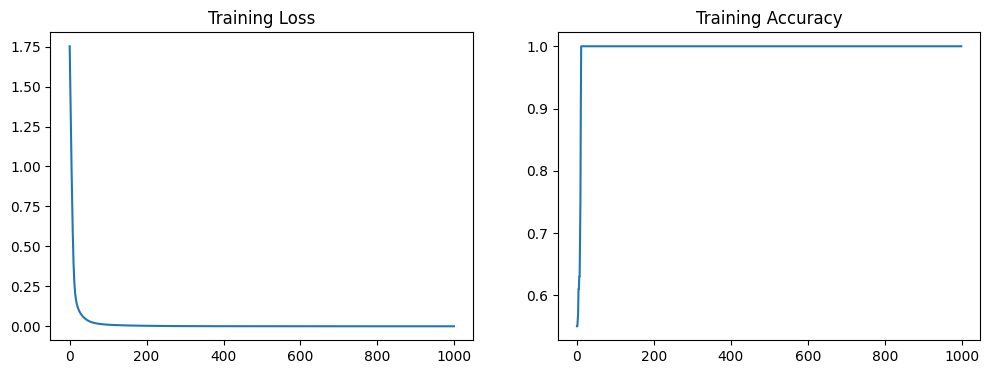


Final accuracy: 1.0000
🎉✅ Excellent! Model learned successfully!


In [ ]:
def test_synthetic_data():
    print("\nTesting on synthetic data...")
    
    X, y = make_classification(n_samples=100, n_features=2, n_classes=2,
                               n_redundant=0, n_clusters_per_class=1, random_state=42)
    
    y_onehot = np.eye(2)[y]
    
    model = Sequential([
        Dense(2, 10),
        ReLU(),
        Dense(10, 2),
        Softmax()
    ])
    
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(lr=0.01)
    
    losses, accuracies = [], []
    
    for epoch in range(1000):
        logits = model.forward(X)
        loss = loss_fn.forward(logits, y_onehot)
        
        grad = loss_fn.backward()
        model.backward(grad)
        
        params = model.get_params_and_grads()
        optimizer.step(params)
        
        preds = np.argmax(logits, axis=1)
        acc = np.mean(preds == y)
        losses.append(loss)
        accuracies.append(acc)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(losses)
    axes[0].set_title('Training Loss')
    axes[1].plot(accuracies)
    axes[1].set_title('Training Accuracy')
    plt.show()
    
    print(f"\nFinal accuracy: {accuracies[-1]:.4f}")
    if accuracies[-1] > 0.9:
        print(" Excellent! Model learned successfully!")
    elif accuracies[-1] > 0.7:
        print(" Good! Model is learning!")
    else:
        print(" Model might need tuning.")

test_synthetic_data()

### 4. Chargement de MNIST

In [17]:
def load_mnist():
    url = 'https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz'
    filename = 'mnist.pkl.gz'
    
    if not os.path.exists(filename):
        print("Downloading MNIST dataset...")
        urllib.request.urlretrieve(url, filename)
    
    with gzip.open(filename, 'rb') as f:
        train, val, test = pickle.load(f, encoding='latin1')
    
    X_train, y_train = train
    X_val, y_val = val
    X_test, y_test = test
    
    # Normalisation entre 0 et 1 (MNIST original est 0-255)
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    
    # One-hot encoding
    y_train_1h = np.eye(10)[y_train.astype(int)]
    y_val_1h = np.eye(10)[y_val.astype(int)]
    y_test_1h = np.eye(10)[y_test.astype(int)]
    
    return (X_train, y_train, y_train_1h), (X_val, y_val, y_val_1h), (X_test, y_test, y_test_1h)

print("Loading MNIST dataset...")
(X_train, y_train, y_train_onehot), (X_val, y_val, y_val_onehot), (X_test, y_test, y_test_onehot) = load_mnist()
print(f"Training data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print(f"Test data: {X_test.shape}")

Loading MNIST dataset...
Training data: (50000, 784)
Validation data: (10000, 784)
Test data: (10000, 784)


### 5. Entraînement sur MNIST


Training on MNIST...
Epoch 1/10 - Train loss: 0.8906, Train acc: 0.7332, Val loss: 0.4309, Val acc: 0.8793
Epoch 2/10 - Train loss: 0.4066, Train acc: 0.8814, Val loss: 0.3327, Val acc: 0.9024
Epoch 3/10 - Train loss: 0.3421, Train acc: 0.9009, Val loss: 0.2953, Val acc: 0.9159
Epoch 4/10 - Train loss: 0.3060, Train acc: 0.9107, Val loss: 0.2722, Val acc: 0.9228
Epoch 5/10 - Train loss: 0.2792, Train acc: 0.9189, Val loss: 0.2554, Val acc: 0.9272
Epoch 6/10 - Train loss: 0.2570, Train acc: 0.9248, Val loss: 0.2317, Val acc: 0.9305
Epoch 7/10 - Train loss: 0.2375, Train acc: 0.9307, Val loss: 0.2146, Val acc: 0.9377
Epoch 8/10 - Train loss: 0.2192, Train acc: 0.9357, Val loss: 0.2127, Val acc: 0.9376
Epoch 9/10 - Train loss: 0.2025, Train acc: 0.9406, Val loss: 0.1864, Val acc: 0.9463
Epoch 10/10 - Train loss: 0.1860, Train acc: 0.9447, Val loss: 0.1750, Val acc: 0.9501


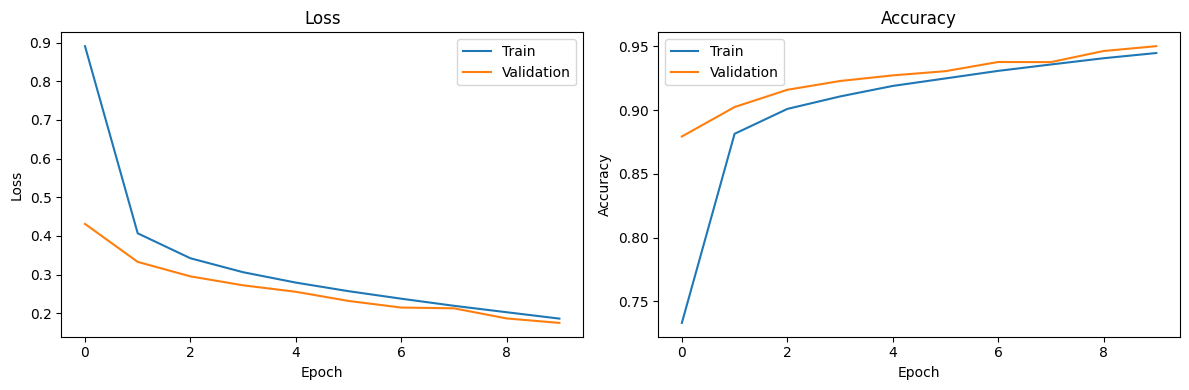


 Final Test Accuracy: 0.9440


In [18]:
def train_mnist():
    print("\nTraining on MNIST...")
    model = Sequential([
        Dense(784, 128),
        ReLU(),
        Dense(128, 64),
        ReLU(),
        Dense(64, 10),
        Softmax()
    ])
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(lr=0.001)
    
    batch_size = 32
    n_epochs = 10
    n_batches = len(X_train) // batch_size
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        indices = np.random.permutation(len(X_train))
        X_train_shuf = X_train[indices]
        y_train_shuf = y_train_onehot[indices]
        
        for batch_idx in range(n_batches):
            start = batch_idx * batch_size
            end = start + batch_size
            X_batch = X_train_shuf[start:end]
            y_batch = y_train_shuf[start:end]
            logits = model.forward(X_batch)
            loss = loss_fn.forward(logits, y_batch)
            grad = loss_fn.backward()
            model.backward(grad)
            params = model.get_params_and_grads()
            optimizer.step(params)
            preds = np.argmax(logits, axis=1)
            true_labels = np.argmax(y_batch, axis=1)
            acc = np.mean(preds == true_labels)
            epoch_loss += loss
            epoch_accuracy += acc
        
        avg_loss = epoch_loss / n_batches
        avg_acc = epoch_accuracy / n_batches
        train_losses.append(avg_loss)
        train_acc.append(avg_acc)
        
        val_logits = model.forward(X_val)
        val_loss = loss_fn.forward(val_logits, y_val_onehot)
        val_preds = np.argmax(val_logits, axis=1)
        val_accuracy = np.mean(val_preds == y_val)
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train loss: {avg_loss:.4f}, Train acc: {avg_acc:.4f}, "
              f"Val loss: {val_loss:.4f}, Val acc: {val_accuracy:.4f}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_losses, label='Train')
    ax1.plot(val_losses, label='Validation')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_acc, label='Train')
    ax2.plot(val_acc, label='Validation')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    test_logits = model.forward(X_test)
    test_preds = np.argmax(test_logits, axis=1)
    test_accuracy = np.mean(test_preds == y_test)
    print(f"\n Final Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy

test_accuracy = train_mnist()


### 6. Analyse des Résultats (exemple de squelette)

In [23]:
def analyze_results():
    print("\nAnalyzing results...")
    print("For detailed analysis, load trained model weights here if saved.")
    print("Suggestions:")
    print("1. Calculate confusion matrix")
    print("2. Display misclassified examples")
    print("3. Per-class accuracy")
    print("4. Plot learning curves")

analyze_results()


Analyzing results...
For detailed analysis, load trained model weights here if saved.
Suggestions:
1. Calculate confusion matrix
2. Display misclassified examples
3. Per-class accuracy
4. Plot learning curves


### 7. Conclusion Semaine 1

In [ ]:
# -  Tests gradient passés  
# -  Apprentissage données synthétiques validé  
# -  Entraînement MNIST réalisé  
# - Prochaine étape : couches convolutives

print(f"\n Semaine 1 terminée! Test Accuracy = {test_accuracy:.4f}")
print("Prochaine étape : Implémentation des couches CNN")


 Semaine 1 terminée! Test Accuracy = 0.9440
Prochaine étape : Implémentation des couches CNN
